In [4]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv("./data/student_lifestyle_dataset.csv")
df = pd.get_dummies(df,columns=["Stress_Level"], drop_first=True)
X = df.drop(labels = ["GPA", "Student_ID"], axis=1)
y = df["GPA"]
print(X.columns)
full_reg = LinearRegression().fit(X,y)

Index(['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day',
       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day',
       'Physical_Activity_Hours_Per_Day', 'Stress_Level_Low',
       'Stress_Level_Moderate'],
      dtype='object')


In [5]:
print(df.var())

Student_ID                         333500.000000
Study_Hours_Per_Day                     2.027458
Extracurricular_Hours_Per_Day           1.336000
Sleep_Hours_Per_Day                     2.134371
Social_Hours_Per_Day                    2.851080
Physical_Activity_Hours_Per_Day         6.320749
GPA                                     0.089206
Stress_Level_Low                        0.126511
Stress_Level_Moderate                   0.223543
dtype: float64


In [6]:
#evaluating the full model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

y_pred = full_reg.predict(X)

n = X.shape[0] 
p = X.shape[1] 

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R2: {r2}, adjR2: {adj_r2}, MSE: {mse}, RMSE: {rmse}")

R2: 0.5417504784010405, adjR2: 0.5401401638171084, MSE: 0.040858113171951635, RMSE: 0.2021338991162829


In [7]:
#Using BIC as the selection criterion 
def bic(model, X, y):
    y_hat = model.predict(X) 
    residuals = y - y_hat 
    rss  = np.sum(residuals ** 2)
    p = X.shape[1]
    n = X.shape[0]
    return n*np.log(rss/n) + (p + 1)*np.log(n)


In [8]:
from  sklearn.feature_selection import SequentialFeatureSelector

forward_sfs = SequentialFeatureSelector(LinearRegression(),n_features_to_select="auto",direction="forward",scoring=bic)
forward_sfs.fit(X,y)
selected_mask = forward_sfs.get_support()
selected_features = X.columns[selected_mask]
print(selected_features)

backward = SequentialFeatureSelector(LinearRegression(),n_features_to_select="auto",direction="backward",scoring=bic)
backward_sfs.fit(X,y)
selected_mask = backward_sfs.get_support()
selected_features = X.columns[selected_mask]
print(selected_features)

Index(['Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day',
       'Social_Hours_Per_Day'],
      dtype='object')


NameError: name 'backward_sfs' is not defined

In [9]:
#switching to stats models for the F test 
from statsmodels.stats.diagnostic import compare_encompassing
import statsmodels.formula.api as smf
m0 = smf.ols("GPA ~ Extracurricular_Hours_Per_Day + Sleep_Hours_Per_Day + Social_Hours_Per_Day", data=df).fit()
m1 = smf.ols("GPA ~ Study_Hours_Per_Day + Sleep_Hours_Per_Day + Social_Hours_Per_Day + Physical_Activity_Hours_Per_Day", data=df).fit()
cmp = compare_encompassing(m0, m1)
print(cmp)

ValueError: The exog in results_x and in results_z are nested. Testing encompassing requires that models are non-nested.


In [10]:
#the above failure shows there's some *exact* colinearity 
#this is confirmed by the rank of the predictors matrix becing 1 lower than its column count
#this is because the number of hours, for every row, will sum to 24
#to account for this we remove one of the hours columns from the data set, and refit the models
import numpy as np
import statsmodels.api as sm
X = df[[
    "Extracurricular_Hours_Per_Day",
    "Study_Hours_Per_Day",
    "Sleep_Hours_Per_Day",
    "Social_Hours_Per_Day",
    "Physical_Activity_Hours_Per_Day",
]]
X = sm.add_constant(X)

rank = np.linalg.matrix_rank(X)
n_cols = X.shape[1]
print("rank:", rank, "n_cols:", n_cols)
cond_number = np.linalg.cond(X)
print("condition number:", cond_number)

rank: 5 n_cols: 6
condition number: 1.5579303813916428e+16


In [11]:
from  sklearn.feature_selection import SequentialFeatureSelector
X = df.drop(labels = ["GPA", "Student_ID", "Extracurricular_Hours_Per_Day"], axis=1)
y = df["GPA"]

forward_sfs = SequentialFeatureSelector(LinearRegression(),n_features_to_select="auto",direction="forward",scoring=bic)
forward_sfs.fit(X,y)
selected_mask = forward_sfs.get_support()
selected_features = X.columns[selected_mask]
print(selected_features)

backward = SequentialFeatureSelector(LinearRegression(),n_features_to_select="auto",direction="backward",scoring=bic)
backward_sfs.fit(X,y)
selected_mask = backward_sfs.get_support()
selected_features = X.columns[selected_mask]
print(selected_features)
#since both the forward and backwards selection agree, we can conclude that this is the best model. 
#all of the hourly measures were meaningful, and the only column that was not effectual is the low stress column
#interpretively, we can say that this means that a student being low stress does not strongly correlate one way or the other
#but it matters much more if they are moderatly or high stress, and how they distribute their day

Index(['Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Stress_Level_Moderate'], dtype='object')


NameError: name 'backward_sfs' is not defined

In [12]:
import pandas as pd
from  sklearn.feature_selection import SequentialFeatureSelector
df = pd.read_csv("./data/student_lifestyle_dataset.csv")
df['Stress_Level'] = df['Stress_Level'].map({
    'Low': 1,
    'Moderate': 2,
    'High': 3
})
X = df.drop(labels = ["GPA", "Student_ID", "Extracurricular_Hours_Per_Day"], axis=1)
y = df["GPA"]

forward_sfs = SequentialFeatureSelector(LinearRegression(),n_features_to_select="auto",direction="forward",scoring="explained_variance")
forward_sfs.fit(X,y)
selected_mask = forward_sfs.get_support()
selected_features = X.columns[selected_mask]
print(selected_features)

Index(['Study_Hours_Per_Day', 'Sleep_Hours_Per_Day'], dtype='object')


In [13]:
forward_sfs = SequentialFeatureSelector(
    LinearRegression(),n_features_to_select="auto",direction="forward",scoring=bic)
forward_sfs.fit(X,y)
selected_mask = forward_sfs.get_support()
selected_features = X.columns[selected_mask]
print(selected_features)

Index(['Sleep_Hours_Per_Day', 'Social_Hours_Per_Day'], dtype='object')


In [14]:
forward_sfs = SequentialFeatureSelector(
    LinearRegression(),n_features_to_select="auto",direction="forward",scoring="neg_mean_squared_error")
forward_sfs.fit(X,y)
selected_mask = forward_sfs.get_support()
selected_features = X.columns[selected_mask]
print(selected_features)

Index(['Study_Hours_Per_Day', 'Sleep_Hours_Per_Day'], dtype='object')


In [15]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
m_full = smf.ols(
    "GPA ~ Study_Hours_Per_Day"
    "+ Sleep_Hours_Per_Day + Social_Hours_Per_Day "
    "+ Physical_Activity_Hours_Per_Day"
    "+ Stress_Level",
    data=df
).fit()
print(m_full.rsquared)

m_restricted = smf.ols(
    "GPA ~ Study_Hours_Per_Day + Sleep_Hours_Per_Day",
    data=df
).fit()
print(m_restricted.rsquared)

anova_results = anova_lm(m_restricted, m_full)
print(anova_results)
#we can reject the null hypothesis, so stress, EC, Sleep, and Physical do not contribute meaningfully to the regression

0.5409677946725513
0.540014901183212
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0    1997.0  82.025719      0.0       NaN       NaN       NaN
1    1994.0  81.855797      3.0  0.169922  1.379765  0.247144


In [16]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
m_full = smf.ols(
    "GPA ~ Study_Hours_Per_Day + Extracurricular_Hours_Per_Day "
    "+ Sleep_Hours_Per_Day + Social_Hours_Per_Day "
    "+ Physical_Activity_Hours_Per_Day",
    data=df
).fit()
print(m_full.rsquared)
m_restricted = smf.ols(
    "GPA ~ Sleep_Hours_Per_Day + Social_Hours_Per_Day",
    data=df
).fit()
anova_results = anova_lm(m_restricted, m_full)
print(anova_results)
#BIC selected model does not fully explain variance

0.5409677050298489
   df_resid         ssr  df_diff    ss_diff            F  Pr(>F)
0    1997.0  176.932938      0.0        NaN          NaN     NaN
1    1995.0   81.855812      2.0  95.077126  1158.615743     0.0


In [22]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
m_full = smf.ols(
    "GPA ~ Study_Hours_Per_Day + Stress_Level",
    data=df
).fit()
print(m_full.rsquared)
m_restricted = smf.ols(
    "GPA ~ Study_Hours_Per_Day",
    data=df
).fit()
anova_results = anova_lm(m_restricted, m_full)
print(anova_results)
print("sleep + study")
print("MSE (residual):", m_full.mse_resid)   # σ² estimate, usual MSE of errors
print("MSE (model):",    m_full.mse_model)   # mean square due to regression
print("MSE (total):",    m_full.mse_total)   # mean square of y around its mean
print("study")
print("MSE (residual):", m_restricted.mse_resid)   # σ² estimate, usual MSE of errors
print("MSE (model):",    m_restricted.mse_model)   # mean square due to regression
print("MSE (total):",    m_restricted.mse_total)   # mean square of y around its mean
print(m_restricted.f_pvalue)

0.5395750712812433
   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0    1998.0  82.127664      0.0       NaN       NaN       NaN
1    1997.0  82.104151      1.0  0.023513  0.571902  0.449593
sleep + study
MSE (residual): 0.04111374587059913
MSE (model): 48.109203148206774
MSE (total): 0.08920588134067034
study
MSE (residual): 0.04110493669795589
MSE (model): 96.19489327748414
MSE (total): 0.08920588134067034
0.0


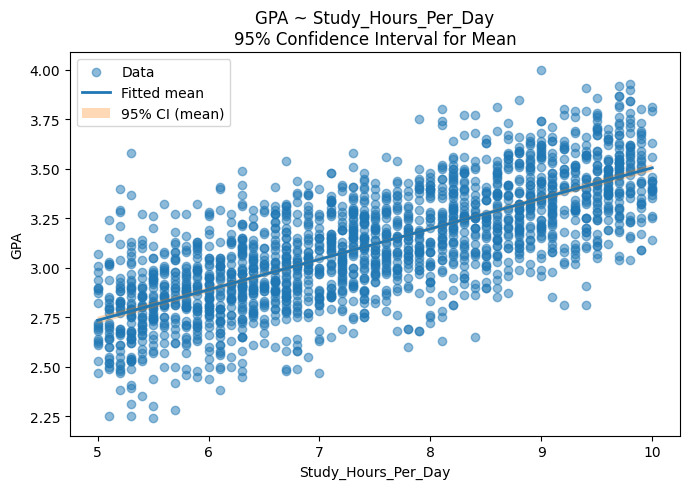

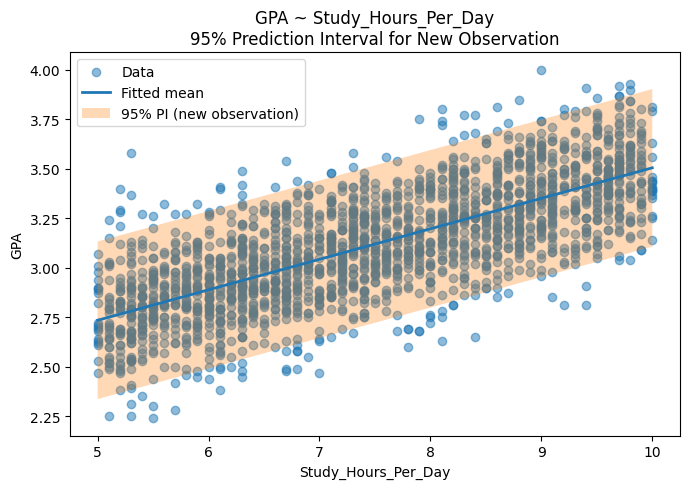

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x_name = "Study_Hours_Per_Day"
y_name = "GPA"

# 1. Grid of x values
x_min = df[x_name].min()
x_max = df[x_name].max()
x_grid = np.linspace(x_min, x_max, 200)
grid = pd.DataFrame({x_name: x_grid})

# 2. Prediction summary frame
pred = m_restricted.get_prediction(grid)
pred_sf = pred.summary_frame(alpha=0.05)  # 95%

# ----------------------------------------------------------------------
# Figure 1: Confidence interval (CI) for the mean
# ----------------------------------------------------------------------
plt.figure(figsize=(7, 5))

# Raw data
plt.scatter(df[x_name], df[y_name], alpha=0.5, label="Data")

# Fitted mean
plt.plot(x_grid, pred_sf["mean"], linewidth=2, label="Fitted mean")

# 95% CI band (mean response)
plt.fill_between(
    x_grid,
    pred_sf["mean_ci_lower"],
    pred_sf["mean_ci_upper"],
    alpha=0.3,
    label="95% CI (mean)"
)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title("GPA ~ Study_Hours_Per_Day\n95% Confidence Interval for Mean")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Figure 2: Prediction interval (PI) for a new observation
# ----------------------------------------------------------------------
plt.figure(figsize=(7, 5))

# Raw data
plt.scatter(df[x_name], df[y_name], alpha=0.5, label="Data")

# Fitted mean
plt.plot(x_grid, pred_sf["mean"], linewidth=2, label="Fitted mean")

# 95% PI band (new obs)
plt.fill_between(
    x_grid,
    pred_sf["obs_ci_lower"],
    pred_sf["obs_ci_upper"],
    alpha=0.3,
    label="95% PI (new observation)"
)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title("GPA ~ Study_Hours_Per_Day\n95% Prediction Interval for New Observation")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
pred_sf = m_restricted.get_prediction(grid).summary_frame(alpha=0.05)
print(pred_sf[["mean_ci_lower", "mean", "mean_ci_upper"]].head())
print(pred_sf[["obs_ci_lower", "mean", "obs_ci_upper"]].head())


   mean_ci_lower      mean  mean_ci_upper
0       2.716698  2.734535       2.752372
1       2.720705  2.738406       2.756107
2       2.724711  2.742277       2.759842
3       2.728717  2.746148       2.763578
4       2.732723  2.750018       2.767314
   obs_ci_lower      mean  obs_ci_upper
0      2.336524  2.734535      3.132546
1      2.340401  2.738406      3.136411
2      2.344278  2.742277      3.140275
3      2.348155  2.746148      3.144140
4      2.352032  2.750018      3.148005


In [23]:
pred_sf = m_restricted.get_prediction(grid).summary_frame(alpha=0.05)

print(pred_sf[["mean_ci_lower", "mean", "mean_ci_upper"]]
      .head()
      .round(3))

print(pred_sf[["obs_ci_lower", "mean", "obs_ci_upper"]]
      .head()
      .round(3))


   mean_ci_lower   mean  mean_ci_upper
0          2.717  2.735          2.752
1          2.721  2.738          2.756
2          2.725  2.742          2.760
3          2.729  2.746          2.764
4          2.733  2.750          2.767
   obs_ci_lower   mean  obs_ci_upper
0         2.337  2.735         3.133
1         2.340  2.738         3.136
2         2.344  2.742         3.140
3         2.348  2.746         3.144
4         2.352  2.750         3.148


In [29]:
x = df[x_name]
qs = x.quantile([0.25, 0.5, 0.75])   # Q1, median, Q3
grid_q = pd.DataFrame({x_name: qs.values})

pred_q = m_restricted.get_prediction(grid_q).summary_frame(alpha=0.05)
print(pred_q[["mean_ci_lower", "mean", "mean_ci_upper"]])
print(pred_q[["obs_ci_lower", "mean", "obs_ci_upper"]])


   mean_ci_lower      mean  mean_ci_upper
0       2.923283  2.934815       2.946346
1       3.095379  3.104282       3.113186
2       3.292836  3.304562       3.316288
   obs_ci_lower      mean  obs_ci_upper
0      2.537037  2.934815      3.332593
1      2.706572  3.104282      3.501993
2      2.906778  3.304562      3.702346


In [27]:
qs = df[x_name].quantile([0.25, 0.5, 0.75])
print(qs)

0.25    6.3
0.50    7.4
0.75    8.7
Name: Study_Hours_Per_Day, dtype: float64
